In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 1.2 MB 6.6 MB/s 


In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [5]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [6]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [7]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [8]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [9]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [10]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [11]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [12]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [13]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [14]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [15]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            #for lr_scheduler in lr_schedulers:
                #lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model        
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))

    if plot:
        plot_results(results, title)
    return results

In [16]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mfcc.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [17]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [18]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.952 / Validation Loss : 3.378 [Time : 19.02383 seconds]
Epoch 2/10 : Training Loss: 3.459 / Validation Loss : 3.173 [Time : 18.9079 seconds]
Epoch 3/10 : Training Loss: 3.263 / Validation Loss : 2.994 [Time : 18.850065 seconds]
Epoch 4/10 : Training Loss: 3.054 / Validation Loss : 2.800 [Time : 18.841508 seconds]
Epoch 5/10 : Training Loss: 2.889 / Validation Loss : 2.631 [Time : 18.862178 seconds]
Epoch 6/10 : Training Loss: 2.712 / Validation Loss : 2.474 [Time : 18.91585 seconds]
Epoch 7/10 : Training Loss: 2.507 / Validation Loss : 2.241 [Time : 18.93268 seconds]
Epoch 8/10 : Training Loss: 2.317 / Validati

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.754 / Validation Loss : 3.195 [Time : 18.174898 seconds]
Epoch 2/10 : Training Loss: 3.280 / Validation Loss : 3.049 [Time : 18.147926 seconds]
Epoch 3/10 : Training Loss: 3.061 / Validation Loss : 2.769 [Time : 18.226467 seconds]
Epoch 4/10 : Training Loss: 2.808 / Validation Loss : 2.458 [Time : 18.270764 seconds]
Epoch 5/10 : Training Loss: 2.530 / Validation Loss : 2.221 [Time : 18.263654 seconds]
Epoch 6/10 : Training Loss: 2.263 / Validation Loss : 1.997 [Time : 18.207394 seconds]
Epoch 7/10 : Training Loss: 2.040 / Validation Loss : 1.782 [Time : 18.917341 seconds]
Epoch 8/10 : Training Loss: 1.800 / Validation Loss : 1.579 [Time : 18.985236 seconds]
Epoch 9/10 : Training Loss: 1.586 / Validation Loss : 1.407 [Time : 19.012139 seconds]
Epoch 10/10 : Training Loss: 1.394 / Validation Loss : 1.239 [Time : 19.298766 seconds]
*** Confusion Matrix - Training ***
[[26  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  1  0  0  0  1  0  0
   0  0  0  0  0  1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.987 / Validation Loss : 3.459 [Time : 18.16909 seconds]
Epoch 2/10 : Training Loss: 3.541 / Validation Loss : 3.368 [Time : 18.17851 seconds]
Epoch 3/10 : Training Loss: 3.466 / Validation Loss : 3.242 [Time : 18.156193 seconds]
Epoch 4/10 : Training Loss: 3.318 / Validation Loss : 3.134 [Time : 18.143677 seconds]
Epoch 5/10 : Training Loss: 3.221 / Validation Loss : 3.018 [Time : 18.157283 seconds]
Epoch 6/10 : Training Loss: 3.101 / Validation Loss : 2.907 [Time : 18.264494 seconds]
Epoch 7/10 : Training Loss: 3.019 / Validation Loss : 2.810 [Time : 18.111344 seconds]
Epoch 8/10 : Training Loss: 2.920 / Validation Loss : 2.709 [Time : 18.151033 seconds]
Epoch 9/10 : Training Loss: 2.776 / Validation Loss : 2.605 [Time : 18.146218 seconds]
Epoch 10/10 : Training Loss: 2.679 / Validation Loss : 2.497 [Time : 18.18529 seconds]
*** Confusion Matrix - Training ***
[[ 3  1  2  0  1  0  4  1  1  0  0  0  1  1  0  0  2  1  1  0  3  0  0  7
   0  0  0  0  0  3]
 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.402 / Validation Loss : 3.394 [Time : 18.204377 seconds]
Epoch 2/10 : Training Loss: 3.392 / Validation Loss : 3.388 [Time : 18.1313 seconds]
Epoch 3/10 : Training Loss: 3.386 / Validation Loss : 3.378 [Time : 18.139741 seconds]
Epoch 4/10 : Training Loss: 3.375 / Validation Loss : 3.366 [Time : 18.157881 seconds]
Epoch 5/10 : Training Loss: 3.363 / Validation Loss : 3.353 [Time : 18.10093 seconds]
Epoch 6/10 : Training Loss: 3.349 / Validation Loss : 3.336 [Time : 18.145713 seconds]
Epoch 7/10 : Training Loss: 3.336 / Validation Loss : 3.324 [Time : 18.189029 seconds]
Epoch 8/10 : Training Loss: 3.316 / Validation Loss : 3.299 [Time : 18.174969 seconds]
Epoch 9/10 : Training Loss: 3.294 / Validation Loss : 3.272 [Time : 18.14684 seconds]
Epoch 10/10 : Training Loss: 3.266 / Validation Loss : 3.250 [Time : 18.173526 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0 10  0  0  0  0  0  0 14
   0  0  0  0  0  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.613 / Validation Loss : 3.217 [Time : 18.168366 seconds]
Epoch 2/10 : Training Loss: 3.293 / Validation Loss : 2.732 [Time : 18.141823 seconds]
Epoch 3/10 : Training Loss: 2.853 / Validation Loss : 2.322 [Time : 18.181517 seconds]
Epoch 4/10 : Training Loss: 2.388 / Validation Loss : 1.917 [Time : 18.183649 seconds]
Epoch 5/10 : Training Loss: 1.940 / Validation Loss : 1.545 [Time : 18.125704 seconds]
Epoch 6/10 : Training Loss: 1.604 / Validation Loss : 1.302 [Time : 18.183084 seconds]
Epoch 7/10 : Training Loss: 1.277 / Validation Loss : 1.038 [Time : 18.842993 seconds]
Epoch 8/10 : Training Loss: 1.063 / Validation Loss : 0.851 [Time : 18.864853 seconds]
Epoch 9/10 : Training Loss: 0.909 / Validation Loss : 0.731 [Time : 18.982029 seconds]
Epoch 10/10 : Training Loss: 0.710 / Validation Loss : 0.580 [Time : 18.8735 seconds]
*** Confusion Matrix - Training ***
[[31  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0  0  0  0]


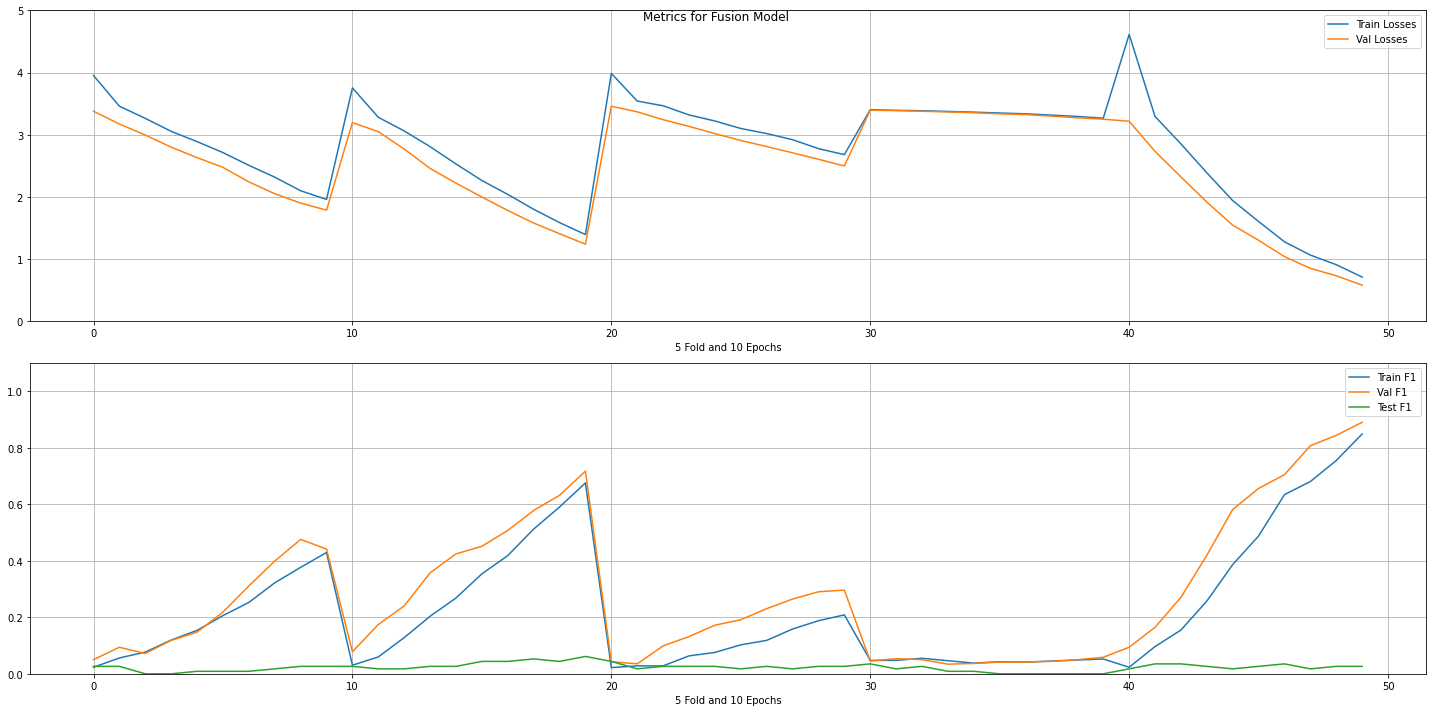

In [19]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [20]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.848780,0.890244,0.026316,0.848780,0.890244,0.026316,0.848780,0.890244,0.026316
8,0.754878,0.843902,0.026316,0.754878,0.843902,0.026316,0.754878,0.843902,0.026316
7,0.680488,0.807317,0.017544,0.680488,0.807317,0.017544,0.680488,0.807317,0.017544
9,0.675610,0.717073,0.061404,0.675610,0.717073,0.061404,0.675610,0.717073,0.061404
6,0.634146,0.704878,0.035088,0.634146,0.704878,0.035088,0.634146,0.704878,0.035088
5,0.487805,0.656098,0.026316,0.487805,0.656098,0.026316,0.487805,0.656098,0.026316
8,0.590244,0.631707,0.043860,0.590244,0.631707,0.043860,0.590244,0.631707,0.043860
4,0.386585,0.581707,0.017544,0.386585,0.581707,0.017544,0.386585,0.581707,0.017544
7,0.512195,0.578049,0.052632,0.512195,0.578049,0.052632,0.512195,0.578049,0.052632
6,0.418293,0.507317,0.043860,0.418293,0.507317,0.043860,0.418293,0.507317,0.043860


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 4.295 / Validation Loss : 3.357 [Time : 21.612315 seconds]
Epoch 2/10 : Training Loss: 3.482 / Validation Loss : 3.207 [Time : 21.603025 seconds]
Epoch 3/10 : Training Loss: 3.270 / Validation Loss : 3.002 [Time : 21.928009 seconds]
Epoch 4/10 : Training Loss: 3.144 / Validation Loss : 2.901 [Time : 21.868037 seconds]
Epoch 5/10 : Training Loss: 2.986 / Validation Loss : 2.665 [Time : 21.932834 seconds]
Epoch 6/10 : Training Loss: 2.783 / Validation Loss : 2.430 [Time : 21.790027 seconds]
Epoch 7/10 : Training Loss: 2.575 / Validation Loss : 2.303 [Time : 21.792334 seconds]
Epoch 8/10 : Training Loss: 2.380 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.548 / Validation Loss : 3.364 [Time : 18.183094 seconds]
Epoch 2/10 : Training Loss: 3.385 / Validation Loss : 3.144 [Time : 17.952079 seconds]
Epoch 3/10 : Training Loss: 3.189 / Validation Loss : 3.005 [Time : 17.984092 seconds]
Epoch 4/10 : Training Loss: 3.066 / Validation Loss : 2.872 [Time : 17.968737 seconds]
Epoch 5/10 : Training Loss: 2.934 / Validation Loss : 2.718 [Time : 17.933129 seconds]
Epoch 6/10 : Training Loss: 2.772 / Validation Loss : 2.563 [Time : 17.994447 seconds]
Epoch 7/10 : Training Loss: 2.628 / Validation Loss : 2.412 [Time : 18.018672 seconds]
Epoch 8/10 : Training Loss: 2.474 / Validation Loss : 2.273 [Time : 17.972145 seconds]
Epoch 9/10 : Training Loss: 2.315 / Validation Loss : 2.115 [Time : 17.988565 seconds]
Epoch 10/10 : Training Loss: 2.173 / Validation Loss : 1.977 [Time : 17.938621 seconds]
*** Confusion Matrix - Training ***
[[15  0  0  0  1  0  0  1  0  0  4  0  1  2  0  1  0  2  1  0  2  0  0  0
   1  0  1  0  0  1

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.477 / Validation Loss : 3.369 [Time : 18.159872 seconds]
Epoch 2/10 : Training Loss: 3.381 / Validation Loss : 3.304 [Time : 17.942893 seconds]
Epoch 3/10 : Training Loss: 3.324 / Validation Loss : 3.251 [Time : 17.882446 seconds]
Epoch 4/10 : Training Loss: 3.275 / Validation Loss : 3.198 [Time : 17.932308 seconds]
Epoch 5/10 : Training Loss: 3.217 / Validation Loss : 3.142 [Time : 17.898208 seconds]
Epoch 6/10 : Training Loss: 3.169 / Validation Loss : 3.084 [Time : 17.959255 seconds]
Epoch 7/10 : Training Loss: 3.108 / Validation Loss : 3.025 [Time : 17.939207 seconds]
Epoch 8/10 : Training Loss: 3.065 / Validation Loss : 2.969 [Time : 17.948985 seconds]
Epoch 9/10 : Training Loss: 2.996 / Validation Loss : 2.910 [Time : 17.927422 seconds]
Epoch 10/10 : Training Loss: 2.953 / Validation Loss : 2.862 [Time : 17.891403 seconds]
*** Confusion Matrix - Training ***
[[ 8  1  1  0  0  0  2  0  2  0  1  1  0  0  0  0  1  3  1  1  1  1  0  2
   0  0  4  1  1  0

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.814 / Validation Loss : 3.338 [Time : 18.202243 seconds]
Epoch 2/10 : Training Loss: 3.454 / Validation Loss : 3.219 [Time : 17.900136 seconds]
Epoch 3/10 : Training Loss: 3.272 / Validation Loss : 3.061 [Time : 17.968835 seconds]
Epoch 4/10 : Training Loss: 3.135 / Validation Loss : 2.912 [Time : 17.941345 seconds]
Epoch 5/10 : Training Loss: 2.970 / Validation Loss : 2.783 [Time : 17.91602 seconds]
Epoch 6/10 : Training Loss: 2.813 / Validation Loss : 2.607 [Time : 17.921917 seconds]
Epoch 7/10 : Training Loss: 2.633 / Validation Loss : 2.447 [Time : 17.972689 seconds]
Epoch 8/10 : Training Loss: 2.509 / Validation Loss : 2.323 [Time : 17.897402 seconds]
Epoch 9/10 : Training Loss: 2.341 / Validation Loss : 2.162 [Time : 17.969489 seconds]
Epoch 10/10 : Training Loss: 2.174 / Validation Loss : 2.001 [Time : 17.930739 seconds]
*** Confusion Matrix - Training ***
[[11  1  0  1  1  0  0  1  0  0  1  0  0  0  0  0  1  0  2  0  4  4  0  0
   2  0  2  2  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.500 / Validation Loss : 3.464 [Time : 18.177854 seconds]
Epoch 2/10 : Training Loss: 3.624 / Validation Loss : 3.121 [Time : 17.899306 seconds]
Epoch 3/10 : Training Loss: 3.310 / Validation Loss : 2.964 [Time : 17.934833 seconds]
Epoch 4/10 : Training Loss: 3.150 / Validation Loss : 2.774 [Time : 17.941358 seconds]
Epoch 5/10 : Training Loss: 2.948 / Validation Loss : 2.598 [Time : 17.889511 seconds]
Epoch 6/10 : Training Loss: 2.761 / Validation Loss : 2.431 [Time : 17.893843 seconds]
Epoch 7/10 : Training Loss: 2.610 / Validation Loss : 2.278 [Time : 17.936006 seconds]
Epoch 8/10 : Training Loss: 2.397 / Validation Loss : 2.076 [Time : 17.895697 seconds]
Epoch 9/10 : Training Loss: 2.172 / Validation Loss : 1.924 [Time : 17.927258 seconds]
Epoch 10/10 : Training Loss: 2.007 / Validation Loss : 1.780 [Time : 17.93134 seconds]
*** Confusion Matrix - Training ***
[[16  0  1  1  0  0  1  3  0  0  1  0  0  2  0  3  0  0  0  0  0  0  0  1
   1  0  0  2  0  1]

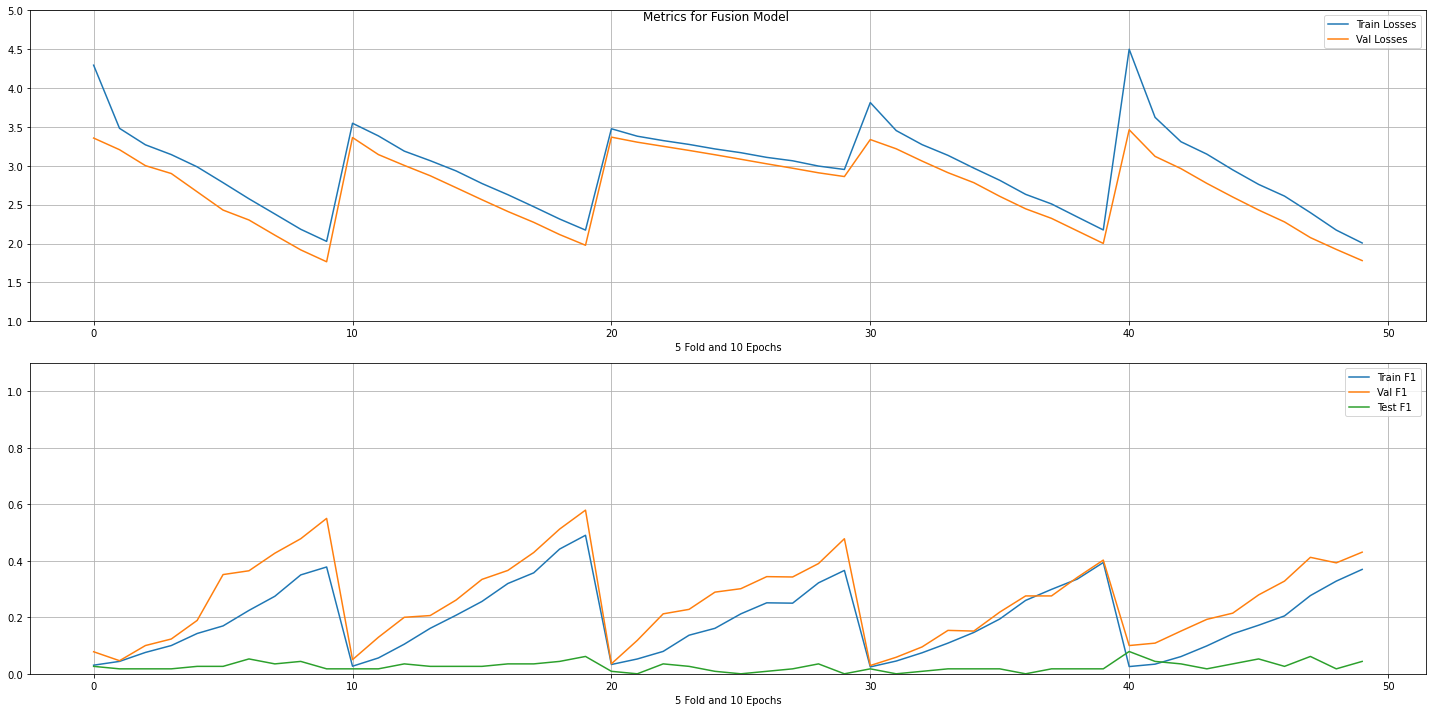

In [21]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [22]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.490244,0.579268,0.061404,0.490244,0.579268,0.061404,0.490244,0.579268,0.061404
9,0.378049,0.550000,0.017544,0.378049,0.550000,0.017544,0.378049,0.550000,0.017544
8,0.441463,0.512195,0.043860,0.441463,0.512195,0.043860,0.441463,0.512195,0.043860
9,0.365854,0.478049,0.000000,0.365854,0.478049,0.000000,0.365854,0.478049,0.000000
8,0.350000,0.478049,0.043860,0.350000,0.478049,0.043860,0.350000,0.478049,0.043860
9,0.369512,0.430488,0.043860,0.369512,0.430488,0.043860,0.369512,0.430488,0.043860
7,0.357317,0.429268,0.035088,0.357317,0.429268,0.035088,0.357317,0.429268,0.035088
7,0.274390,0.426829,0.035088,0.274390,0.426829,0.035088,0.274390,0.426829,0.035088
7,0.276829,0.412195,0.061404,0.276829,0.412195,0.061404,0.276829,0.412195,0.061404
9,0.393902,0.402439,0.017544,0.393902,0.402439,0.017544,0.393902,0.402439,0.017544


# XLM-R Fusion

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.452 / Validation Loss : 3.365 [Time : 23.117757 seconds]
Epoch 2/10 : Training Loss: 3.372 / Validation Loss : 3.321 [Time : 22.806075 seconds]
Epoch 3/10 : Training Loss: 3.334 / Validation Loss : 3.275 [Time : 22.842255 seconds]
Epoch 4/10 : Training Loss: 3.289 / Validation Loss : 3.226 [Time : 23.349285 seconds]
Epoch 5/10 : Training Loss: 3.236 / Validation Loss : 3.172 [Time : 23.086563 seconds]
Epoch 6/10 : Training Loss: 3.186 / Validation Loss : 3.117 [Time : 23.28474 seconds]
Epoch 7/10 : Training Loss: 3.135 / Validation Loss : 3.061 [Time : 22.894246 seconds]
Epoch 8/10 : Training Loss: 3.078 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.473 / Validation Loss : 3.400 [Time : 18.312472 seconds]
Epoch 2/10 : Training Loss: 3.411 / Validation Loss : 3.379 [Time : 18.309168 seconds]
Epoch 3/10 : Training Loss: 3.398 / Validation Loss : 3.369 [Time : 18.317372 seconds]
Epoch 4/10 : Training Loss: 3.390 / Validation Loss : 3.357 [Time : 18.290706 seconds]
Epoch 5/10 : Training Loss: 3.376 / Validation Loss : 3.344 [Time : 18.303484 seconds]
Epoch 6/10 : Training Loss: 3.362 / Validation Loss : 3.327 [Time : 18.263211 seconds]
Epoch 7/10 : Training Loss: 3.349 / Validation Loss : 3.309 [Time : 18.268216 seconds]
Epoch 8/10 : Training Loss: 3.328 / Validation Loss : 3.290 [Time : 18.277571 seconds]
Epoch 9/10 : Training Loss: 3.316 / Validation Loss : 3.278 [Time : 18.310917 seconds]
Epoch 10/10 : Training Loss: 3.305 / Validation Loss : 3.273 [Time : 18.310357 seconds]
*** Confusion Matrix - Training ***
[[18  0  2  1  2  0  0  0  0  4  0  0  0  2  0  0  0  0  0  0  0  1  0  0
   3  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.479 / Validation Loss : 3.390 [Time : 18.598268 seconds]
Epoch 2/10 : Training Loss: 3.412 / Validation Loss : 3.345 [Time : 18.662077 seconds]
Epoch 3/10 : Training Loss: 3.373 / Validation Loss : 3.314 [Time : 18.474223 seconds]
Epoch 4/10 : Training Loss: 3.341 / Validation Loss : 3.284 [Time : 18.295219 seconds]
Epoch 5/10 : Training Loss: 3.309 / Validation Loss : 3.248 [Time : 18.199775 seconds]
Epoch 6/10 : Training Loss: 3.281 / Validation Loss : 3.213 [Time : 18.251721 seconds]
Epoch 7/10 : Training Loss: 3.245 / Validation Loss : 3.175 [Time : 18.298488 seconds]
Epoch 8/10 : Training Loss: 3.199 / Validation Loss : 3.132 [Time : 18.261455 seconds]
Epoch 9/10 : Training Loss: 3.164 / Validation Loss : 3.095 [Time : 18.208128 seconds]
Epoch 10/10 : Training Loss: 3.128 / Validation Loss : 3.050 [Time : 18.249622 seconds]
*** Confusion Matrix - Training ***
[[ 6  2  7  1  0  0  2  0  0  1  0  0  0  0  0  1  4  2  0  0  0  0  0  2
   0  1  0  1  0  2

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 4.645 / Validation Loss : 3.446 [Time : 18.684538 seconds]
Epoch 2/10 : Training Loss: 3.534 / Validation Loss : 3.282 [Time : 18.299934 seconds]
Epoch 3/10 : Training Loss: 3.320 / Validation Loss : 3.086 [Time : 18.28452 seconds]
Epoch 4/10 : Training Loss: 3.143 / Validation Loss : 2.931 [Time : 18.318808 seconds]
Epoch 5/10 : Training Loss: 3.035 / Validation Loss : 2.786 [Time : 22.886915 seconds]
Epoch 6/10 : Training Loss: 2.844 / Validation Loss : 2.661 [Time : 23.918947 seconds]
Epoch 7/10 : Training Loss: 2.665 / Validation Loss : 2.437 [Time : 23.047935 seconds]
Epoch 8/10 : Training Loss: 2.490 / Validation Loss : 2.327 [Time : 23.114848 seconds]
Epoch 9/10 : Training Loss: 2.314 / Validation Loss : 2.135 [Time : 23.29821 seconds]
Epoch 10/10 : Training Loss: 2.174 / Validation Loss : 1.994 [Time : 23.118644 seconds]
*** Confusion Matrix - Training ***
[[14  1  0  0  0  0  0  0  0  0  0  1  1  2  1  0  2  0  1  1  3  0  1  1
   0  0  2  1  1  0]


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.464 / Validation Loss : 3.358 [Time : 18.277131 seconds]
Epoch 2/10 : Training Loss: 3.364 / Validation Loss : 3.294 [Time : 18.333833 seconds]
Epoch 3/10 : Training Loss: 3.305 / Validation Loss : 3.229 [Time : 18.278921 seconds]
Epoch 4/10 : Training Loss: 3.245 / Validation Loss : 3.162 [Time : 18.292259 seconds]
Epoch 5/10 : Training Loss: 3.176 / Validation Loss : 3.086 [Time : 18.264168 seconds]
Epoch 6/10 : Training Loss: 3.103 / Validation Loss : 3.010 [Time : 18.272737 seconds]
Epoch 7/10 : Training Loss: 3.030 / Validation Loss : 2.938 [Time : 18.318138 seconds]
Epoch 8/10 : Training Loss: 2.959 / Validation Loss : 2.857 [Time : 18.302474 seconds]
Epoch 9/10 : Training Loss: 2.870 / Validation Loss : 2.772 [Time : 18.306925 seconds]
Epoch 10/10 : Training Loss: 2.796 / Validation Loss : 2.689 [Time : 18.276525 seconds]
*** Confusion Matrix - Training ***
[[15  0  4  0  0  1  0  1  0  0  2  0  0  0  1  1  0  1  2  0  0  1  3  1
   0  0  0  0  0  0

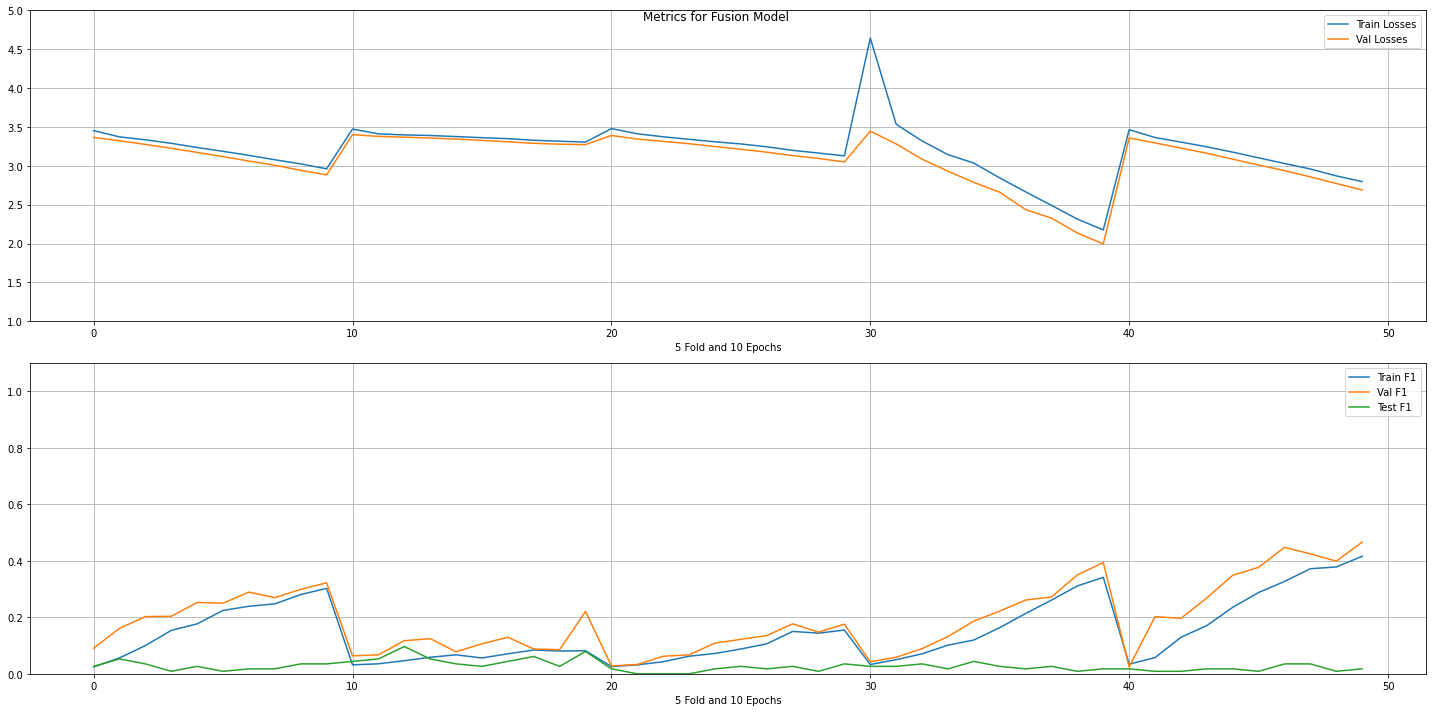

In [23]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [24]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.415854,0.465854,0.017544,0.415854,0.465854,0.017544,0.415854,0.465854,0.017544
6,0.326829,0.447561,0.035088,0.326829,0.447561,0.035088,0.326829,0.447561,0.035088
7,0.371951,0.424390,0.035088,0.371951,0.424390,0.035088,0.371951,0.424390,0.035088
8,0.378049,0.398780,0.008772,0.378049,0.398780,0.008772,0.378049,0.398780,0.008772
9,0.341463,0.393902,0.017544,0.341463,0.393902,0.017544,0.341463,0.393902,0.017544
5,0.287805,0.376829,0.008772,0.287805,0.376829,0.008772,0.287805,0.376829,0.008772
8,0.310976,0.350000,0.008772,0.310976,0.350000,0.008772,0.310976,0.350000,0.008772
4,0.235366,0.348780,0.017544,0.235366,0.348780,0.017544,0.235366,0.348780,0.017544
9,0.302439,0.321951,0.035088,0.302439,0.321951,0.035088,0.302439,0.321951,0.035088
8,0.280488,0.298780,0.035088,0.280488,0.298780,0.035088,0.280488,0.298780,0.035088


# MBERT Fusion

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.457 / Validation Loss : 3.353 [Time : 20.523324 seconds]
Epoch 2/10 : Training Loss: 3.361 / Validation Loss : 3.296 [Time : 20.264233 seconds]
Epoch 3/10 : Training Loss: 3.310 / Validation Loss : 3.245 [Time : 19.71824 seconds]
Epoch 4/10 : Training Loss: 3.273 / Validation Loss : 3.182 [Time : 19.700324 seconds]
Epoch 5/10 : Training Loss: 3.193 / Validation Loss : 3.118 [Time : 19.798618 seconds]
Epoch 6/10 : Training Loss: 3.136 / Validation Loss : 3.055 [Time : 19.719862 seconds]
Epoch 7/10 : Training Loss: 3.083 / Validation Loss : 2.999 [Time : 19.772907 seconds]
Epoch 8/10 : Training Loss: 3.018 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.413 / Validation Loss : 3.375 [Time : 17.233244 seconds]
Epoch 2/10 : Training Loss: 3.372 / Validation Loss : 3.338 [Time : 17.129859 seconds]
Epoch 3/10 : Training Loss: 3.338 / Validation Loss : 3.300 [Time : 17.140269 seconds]
Epoch 4/10 : Training Loss: 3.300 / Validation Loss : 3.258 [Time : 17.130939 seconds]
Epoch 5/10 : Training Loss: 3.262 / Validation Loss : 3.210 [Time : 17.138576 seconds]
Epoch 6/10 : Training Loss: 3.218 / Validation Loss : 3.196 [Time : 17.137499 seconds]
Epoch 7/10 : Training Loss: 3.185 / Validation Loss : 3.145 [Time : 17.111821 seconds]
Epoch 8/10 : Training Loss: 3.147 / Validation Loss : 3.092 [Time : 17.144423 seconds]
Epoch 9/10 : Training Loss: 3.102 / Validation Loss : 3.060 [Time : 17.133192 seconds]
Epoch 10/10 : Training Loss: 3.082 / Validation Loss : 3.011 [Time : 17.132522 seconds]
*** Confusion Matrix - Training ***
[[19  4  5  0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  1
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.599 / Validation Loss : 3.294 [Time : 17.477715 seconds]
Epoch 2/10 : Training Loss: 3.352 / Validation Loss : 3.086 [Time : 17.567296 seconds]
Epoch 3/10 : Training Loss: 3.119 / Validation Loss : 2.881 [Time : 17.507751 seconds]
Epoch 4/10 : Training Loss: 2.922 / Validation Loss : 2.676 [Time : 20.00846 seconds]
Epoch 5/10 : Training Loss: 2.716 / Validation Loss : 2.480 [Time : 19.60377 seconds]
Epoch 6/10 : Training Loss: 2.501 / Validation Loss : 2.284 [Time : 19.696744 seconds]
Epoch 7/10 : Training Loss: 2.293 / Validation Loss : 2.085 [Time : 19.6943 seconds]
Epoch 8/10 : Training Loss: 2.142 / Validation Loss : 1.893 [Time : 19.729926 seconds]
Epoch 9/10 : Training Loss: 1.903 / Validation Loss : 1.704 [Time : 19.633485 seconds]
Epoch 10/10 : Training Loss: 1.755 / Validation Loss : 1.569 [Time : 19.730993 seconds]
*** Confusion Matrix - Training ***
[[17  0  2  0  0  0  0  0  1  0  1  0  0  2  0  0  0  2  0  0  1  0  0  4
   0  0  1  0  0  1]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.500 / Validation Loss : 3.299 [Time : 17.484704 seconds]
Epoch 2/10 : Training Loss: 3.328 / Validation Loss : 3.121 [Time : 17.467249 seconds]
Epoch 3/10 : Training Loss: 3.137 / Validation Loss : 2.955 [Time : 17.550786 seconds]
Epoch 4/10 : Training Loss: 2.986 / Validation Loss : 2.786 [Time : 17.423546 seconds]
Epoch 5/10 : Training Loss: 2.826 / Validation Loss : 2.626 [Time : 17.098378 seconds]
Epoch 6/10 : Training Loss: 2.666 / Validation Loss : 2.453 [Time : 17.110877 seconds]
Epoch 7/10 : Training Loss: 2.502 / Validation Loss : 2.292 [Time : 17.074639 seconds]
Epoch 8/10 : Training Loss: 2.329 / Validation Loss : 2.132 [Time : 17.108186 seconds]
Epoch 9/10 : Training Loss: 2.179 / Validation Loss : 2.001 [Time : 17.129938 seconds]
Epoch 10/10 : Training Loss: 2.032 / Validation Loss : 1.835 [Time : 17.113241 seconds]
*** Confusion Matrix - Training ***
[[20  0  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2  0  2  1  0  1
   0  0  2  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.659 / Validation Loss : 3.221 [Time : 17.385559 seconds]
Epoch 2/10 : Training Loss: 3.258 / Validation Loss : 3.024 [Time : 17.244537 seconds]
Epoch 3/10 : Training Loss: 3.029 / Validation Loss : 2.730 [Time : 17.097788 seconds]
Epoch 4/10 : Training Loss: 2.771 / Validation Loss : 2.465 [Time : 17.101708 seconds]
Epoch 5/10 : Training Loss: 2.490 / Validation Loss : 2.212 [Time : 17.136155 seconds]
Epoch 6/10 : Training Loss: 2.223 / Validation Loss : 1.992 [Time : 17.110524 seconds]
Epoch 7/10 : Training Loss: 1.970 / Validation Loss : 1.735 [Time : 17.13722 seconds]
Epoch 8/10 : Training Loss: 1.760 / Validation Loss : 1.550 [Time : 20.304048 seconds]
Epoch 9/10 : Training Loss: 1.546 / Validation Loss : 1.359 [Time : 19.672446 seconds]
Epoch 10/10 : Training Loss: 1.354 / Validation Loss : 1.196 [Time : 19.745424 seconds]
*** Confusion Matrix - Training ***
[[21  0  0  0  0  0  0  0  1  0  2  0  1  1  0  1  0  0  0  0  0  2  0  1
   0  0  1  0  0  2]

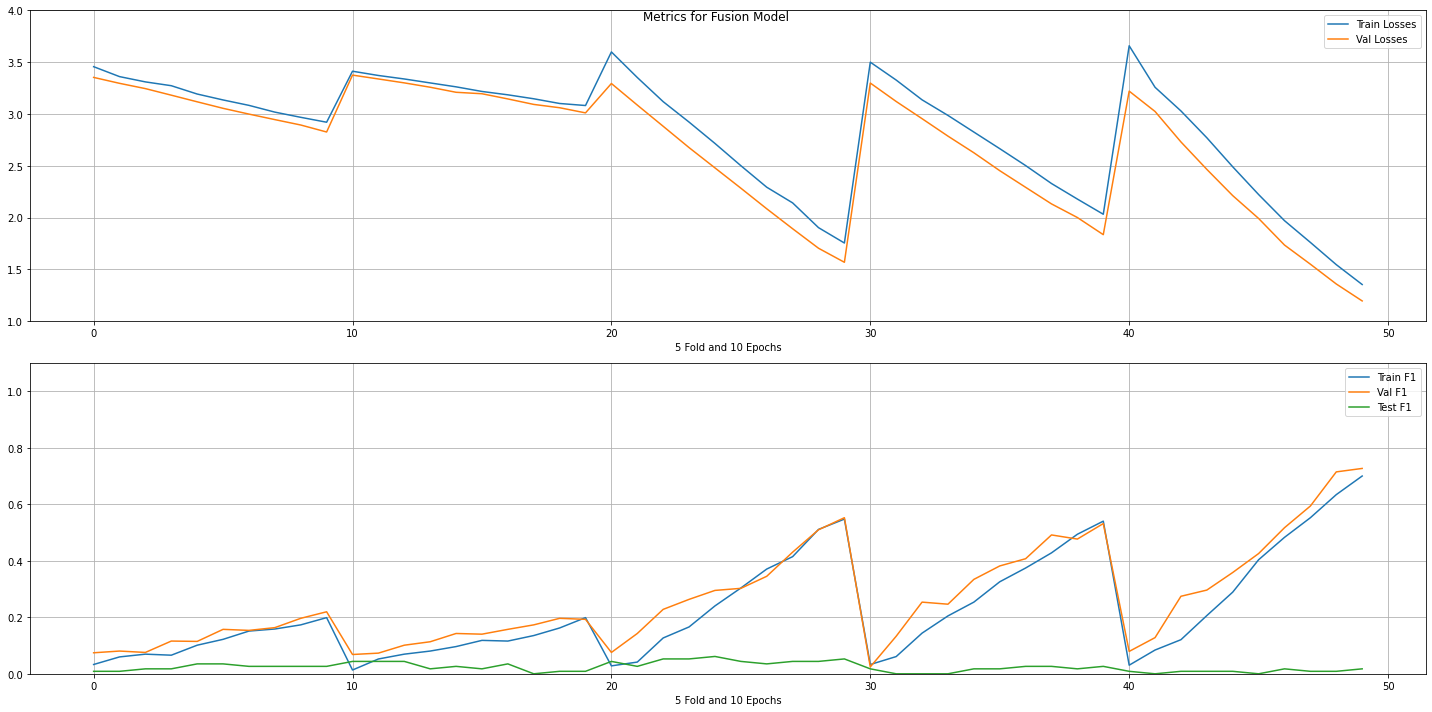

In [25]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [26]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.700000,0.726829,0.017544,0.700000,0.726829,0.017544,0.700000,0.726829,0.017544
8,0.634146,0.714634,0.008772,0.634146,0.714634,0.008772,0.634146,0.714634,0.008772
7,0.552439,0.593902,0.008772,0.552439,0.593902,0.008772,0.552439,0.593902,0.008772
9,0.547561,0.552439,0.052632,0.547561,0.552439,0.052632,0.547561,0.552439,0.052632
9,0.540244,0.531707,0.026316,0.540244,0.531707,0.026316,0.540244,0.531707,0.026316
6,0.482927,0.517073,0.017544,0.482927,0.517073,0.017544,0.482927,0.517073,0.017544
8,0.510976,0.509756,0.043860,0.510976,0.509756,0.043860,0.510976,0.509756,0.043860
7,0.428049,0.491463,0.026316,0.428049,0.491463,0.026316,0.428049,0.491463,0.026316
8,0.493902,0.476829,0.017544,0.493902,0.476829,0.017544,0.493902,0.476829,0.017544
7,0.414634,0.430488,0.043860,0.414634,0.430488,0.043860,0.414634,0.430488,0.043860
